In [9]:
import random
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from GridWorld_v1 import GridWorld_v1
import math

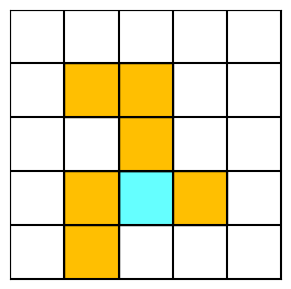

In [10]:
desc = rows = 5  # 记得行数和列数这里要同步改
columns = 5
desc = [".....",".##..","..#..",".#T#.",".#..."]
gridworld = GridWorld_v1(forbidden_area_score=-1, score=1,desc = desc) 
gridworld.show()

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(
            *random.sample(self.buffer, batch_size)
        )
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def size(self):
        # 目前buffer中的元素个数
        return len(self.buffer)

    def __len__(self):
        return len(self.buffer)

In [12]:
class Qnet(torch.nn.Module):
    """只有一层隐藏层的Q网络"""

    def __init__(self,state_dim,hidden_dim1,hidden_dim2,action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim1)
        # self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim1, action_dim)

    def forward(self, x):
        print(f"{x.shape=}")
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        # x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        learning_rate,
        gamma,
        epsilons,
        target_update,
        device,
    ) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,64,32, action_dim).to(device)
        self.target_net = Qnet(state_dim,64,32, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilons = epsilons
        self.epsilon = epsilons[0]
        self.target_update = target_update  # target net 更新频率
        self.count = 0
        self.device = device
        self.loss = nn.MSELoss()

    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                q_value = self.q_net(state)
                return torch.argmax(q_value).item()

    def update(self, transiton_dict):
        states = torch.tensor(transiton_dict["states"], dtype=torch.float32,device=self.device) 
        actions = torch.tensor(transiton_dict["actions"], dtype=torch.long,device=self.device)[:, None] 
        rewards = torch.tensor(transiton_dict["rewards"], dtype=torch.float32,device=self.device)[ :, None ]
        next_states = torch.tensor( transiton_dict["next_states"], dtype=torch.float32,device=self.device)
        dones = torch.tensor(transiton_dict["dones"], dtype=torch.float32,device=self.device)[:, None]

        print(states.shape)
        q_values = self.q_net(states).gather(
            1, actions
        )  # 返回的是一个action_dim维的向量，取出对应的action value的值

        max_next_q_values = self.target_net(next_states).max(dim=1)[0][:, None]
        # max_next_q_values = self.q_net(next_states).max(dim=1)[0][:, None].detach()
        # 只使用一个网络,不使用target_net

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        # print(f"{q_values.shape=}")
        # print(f"{q_targets.shape=}")
        dqn_loss = self.loss(q_values, q_targets)
        # print("loss:", dqn_loss.item())
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
    
    def decay_epsilon(self,i):
        self.epsilon = self.epsilons[i]
        # epsilon = e^(-i/j)
        # self.epsilon = math.exp(-i)
        # self.epsilon = max(0.01, self.epsilon* self.epsilon_decay)
        # print(f"epsilon: {self.epsilon}")

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

In [14]:
lr = 1e-4
num_episodes = 20000
hidden_dim = 12
gamma = 0.9
# epsilon = 1
target_update = 10
buffer_size = 1000
minimal_size = 100
batch_size = 32
epsilon_decay = 0.999
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
reply_buffer = ReplayBuffer(buffer_size)
state_dim = 2
action_dim = 5

cutoff = 3000
epsilon = np.exp(-np.arange(num_episodes) / (cutoff))

epsilon[epsilon > epsilon[100 * int(num_episodes / cutoff)]] = epsilon[
    100 * int(num_episodes / cutoff)
]
agent = DQN(
    state_dim, action_dim, lr, gamma, epsilon, target_update, device
)

In [15]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]

In [16]:
max_v = -100
max_setp =100
for i in range(num_episodes):
    state = gridworld.reset((0,2))
    done = False
    now_reward = 0
    now_step = 0
    while not done and now_step < max_setp:
        now_step += 1
        action = agent.take_action(state)
        next_state, reward, done = gridworld.step(state, action)
        reply_buffer.add(state, action, reward, next_state, done)


        state = next_state
        now_reward += reward

        if len(reply_buffer) > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = reply_buffer.sample(batch_size)
            transiton_dict = {
                "states": b_s,
                "actions": b_a,
                "rewards": b_r,
                "next_states": b_ns,
                "dones": b_d,
            }
            agent.update(transiton_dict)
    agent.decay_epsilon(i)
    # print(f"episode: {i}, reward: {now_reward}")
    if now_reward >= max_v:
        agent.save("model.pth")
        max_v = now_reward
    if i % 30 == 0:
        print(f"episode: {i}, value: {now_reward}")

x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
episode: 0, value: -32.0
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
x.shape=torch.Size([2])
torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([32, 2])
torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([2])
torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([2])
torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([32, 2])
torch.Size([32, 2])
x.shape=torch.Size([32, 2])
x.shape=torch.Size([32,

KeyboardInterrupt: 

[[[-0.57699955  0.30173293  0.2789674   0.08858785 -0.04359417]
  [-0.39706957  0.14985001 -0.1078466   0.29337835 -0.00174092]
  [-0.5459866   0.29234236 -0.10259841  0.25363958  0.03071917]
  [-0.538285    0.30671495  0.2582163   0.28782815  0.1176974 ]
  [-0.54402184 -0.1612078   0.49466315  0.27313614  0.12465563]]

 [[-0.12156495  0.26059142  0.38078496 -0.16099775  0.24778257]
  [-0.14736167 -0.06984425  0.32424465  0.20115277  0.19469857]
  [-0.02691399  0.20141977  0.08552088 -0.17381318 -0.06570046]
  [-0.07764687  0.2924471   0.3334653   0.00823838  0.14964755]
  [-0.16536416 -0.08040804  0.5441618   0.39741886  0.27772602]]

 [[-0.0752082   0.7126209   0.45108917 -0.14600417  0.45407063]
  [ 0.06708397  0.15792528  0.3502567   0.33901298  0.4367438 ]
  [-0.15724714 -0.01235664  0.34836408  0.5130238   0.2811669 ]
  [-0.00301619  0.15611827  0.3944274   0.19826594  0.24603005]
  [-0.07596959 -0.16335297  0.6201501   0.5020066   0.4069225 ]]

 [[-0.04022135  0.7460806   0.4234

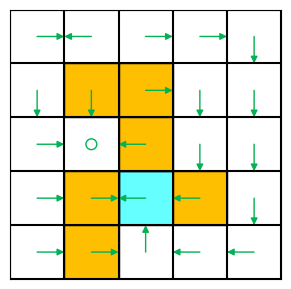

In [27]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]
best_net = Qnet(state_dim,64,32, action_dim).to(device)
best_net.load_state_dict(torch.load("model.pth"))
q_tables = (
    best_net(torch.tensor(gridworld_idx, dtype=torch.float32).to(device))
    .detach()
    .cpu()
    .numpy()
    .reshape(rows, columns, action_dim)
)
# print(f"q_tables_shape:{q_tables.shape}")
print(q_tables)
policy = np.argmax(q_tables, axis=2)
gridworld.show_policy(policy)